In [25]:
import sys
sys.path.append('..')
sys.path.append('../..')
import pandas as pd
import numpy as np
# from QuantData import get_all_trade_days,get_index_weight,get_index_stocks_multdays
# from QuantData import get_index_bonds,get_index_bonds_multdays,read_single_factor_file_nocache
# from QuantData import get_single_factor_values,get_simple_single_factor_values,get_index_stocks,get_sw_desc,get_near_trade_day,get_all_trade_days
# from QuantData import one_hot,get_st_stocks,get_supension_stocks,get_ann_inf_risk_stocks,CB_Data
import datetime
import os
# from WeightOptimizer_210725 import WeightOptimizer
import dcube as dc
from fastcache import lru_cache
%run Quant_useful_packages_ccb.ipynb

pro = dc.pro_api('55bc20c452d523c0a8ce888d15cdb903054761229ab2def8e1ad95c7')
date_s = '20190101'
date_e = '20230701'
date_s = pd.to_datetime(date_s).date()
date_e = pd.to_datetime(date_e).date()
all_days = get_all_trade_days()
date_s0 = all_days[all_days.index(get_near_trade_day(date_s))-20]
date_list = [date for date in all_days if date_s<=date<=date_e]
# bonds_dict = get_index_bonds_multdays('ALLZZ',date_s,date_e)
zzzz_dict = get_index_bonds_multdays('ZZZZ',date_s,date_e)
zzzz_df = get_index_bonds_multdays('ZZZZ',date_s,date_e,True)

In [2]:
# ytm_rank_df = ytm_df.rank(pct=True,axis=1)
# convpremium_ratio_df_tmp = convpremium_ratio_df[convpremium_ratio_df<30]
# for date in ytm_rank_df.index[-10:]:
#     print(date)
#     ccb_list = convpremium_ratio_df_tmp.loc[date].dropna().index.tolist()
# ytm_rank_df.loc[date].reindex(ccb_list).sort_values()

In [61]:
c_1 = 'factor_open_60'
factor_df = ccb_get_single_factor_values(c_1,date_s0,date_e)

In [27]:
outstanding_balance_df = ccb_get_single_factor_values('CCB__outstanding_balance',date_s0,date_e)

In [28]:
pct_df = ccb_get_single_factor_values('CCB__pctchange',date_s0,date_e)/100

In [29]:
ytm_df = ccb_get_single_factor_values('CCB__ytm',date_s0,date_e)

In [30]:
convpremium_ratio_df = ccb_get_single_factor_values('CCB__convpremium_ratio',date_s0,date_e)

In [31]:
amount_df = ccb_get_single_factor_values('CCB__amount',date_s0,date_e)

In [32]:
closeprice_df = ccb_get_single_factor_values('CCB__close',date_s0,date_e)

In [33]:
b_info_creditrating_df = ccb_get_single_factor_values('CCB__b_info_creditrating',date_s0,date_e)

In [34]:
ptm_df = ccb_get_single_factor_values('CCB__ptm',date_s0,date_e)

In [35]:
turn_df = ccb_get_single_factor_values('turn_over',date_s0,date_e)

In [36]:
# b_info_creditrating = b_info_creditrating_df.iloc[-1].dropna()
# low_b_info_creditrating_list = b_info_creditrating[~b_info_creditrating.str.contains('AA')]
# print(len(low_b_info_creditrating_list))
# rating_score = ['AA-','AA','AA+','AAA']
# b_info_creditrating[b_info_creditrating.str.contains('+')]

In [62]:
score_df = {}
weight_multdays_df = {}
factor_df = factor_df.rolling(20,min_periods=5).mean()
for date in date_list[:]:
    date = get_near_trade_day(date)
    pre_date = all_days[all_days.index(date)-1]
    pre5_date = all_days[all_days.index(date)-5]
    if date_list.index(date)%20==0:
        zzzz_list = zzzz_dict[date]
        pct = pct_df.loc[date].reindex(zzzz_list)
        hlimit_list = [s for s in pct[pct>0.198].index.tolist()]
        

        outstanding_balance = outstanding_balance_df.loc[pre_date].reindex(zzzz_list)
        low_outstanding_balance_list = outstanding_balance[outstanding_balance<20000].index.tolist()
#         low_outstanding_balance_list = []
#        ytm_rank = ytm_df.rolling(10,min_periods=3).mean().loc[pre_date].reindex(zzzz_list).rank(pct=True)
#         low_ytm_list = ytm_rank[ytm_rank<0.03].index.tolist()
#         convpremium_ratio = convpremium_ratio_df.loc[pre_date].reindex(zzzz_list)
#         print('convpremium_ratio: {}'.format(convpremium_ratio.median()))
#         print('convpremium_ratio_corr_ytm: {}'.format(convpremium_ratio.corr(ytm_rank)))
#         low_convpremium_ratio_list = convpremium_ratio[convpremium_ratio<-5].index.tolist()
#         high_convpremium_ratio_list = convpremium_ratio[convpremium_ratio>40].index.tolist()
#         low_convpremium_ratio_list = []
#         high_convpremium_ratio_list = []
#        amount_rank = amount_df.rolling(20,min_periods=5).mean().loc[pre_date].reindex(zzzz_list).rank(pct=True)
#        low_amount_list = amount_rank[amount_rank<0.2].index.tolist()
#        closeprice = closeprice_df.loc[pre_date].reindex(zzzz_list)
#        high_closeprice_list = closeprice[closeprice>140].index.tolist()
#        high_closeprice_list = []
        b_info_creditrating = b_info_creditrating_df.loc[pre_date].reindex(zzzz_list).dropna()
        rating_score = ['A','A+','AA-','AA','AA+','AAA']
        low_b_info_creditrating_list = b_info_creditrating[~b_info_creditrating.isin(rating_score)].index.tolist()
        turn_over = turn_df.loc[pre_date].reindex(zzzz_list).dropna()
        high_turnover_list = turn_over[turn_over>1].index.tolist()
        
#        ptm = ptm_df.loc[pre_date].reindex(zzzz_list)
#        low_ptm_list = ptm[ptm<1].index.tolist()
        black_list = low_outstanding_balance_list + low_b_info_creditrating_list+ hlimit_list+ high_turnover_list
#                  low_ptm_list +low_amount_list
#                + low_ytm_list\
#                + low_convpremium_ratio_list\
#                + high_convpremium_ratio_list\
#                + low_amount_list\
#                + high_closeprice_list\

                
        ccb_list = list(set(zzzz_list)-set(black_list))
#        score = factor_df.rolling(20,min_periods=5).mean().loc[pre_date].reindex(ccb_list).rank(ascending=False)
        score = factor_df.loc[pre_date].reindex(ccb_list).rank()
        score_df[date] = score
        port_ccb_list = score[score<=10].index.tolist()
        weight = pd.Series(1,index=port_ccb_list)
        weight = weight/weight.sum()
#         weight[weight>0.1]=0.1
#         weight = weight/weight.sum()
    else:
        pct = pct_df.loc[date].reindex(ccb_list)
        weight = weight * (pct+1)
        weight = weight/weight.sum()
        
    weight_multdays_df[date] = weight
    if date_list.index(date)%60==0:
        print(date,len(ccb_list),len(zzzz_list))
score_df = pd.DataFrame(score_df).T
weight_multdays_df = pd.DataFrame(weight_multdays_df).T

2019-01-02 40 111
2019-04-03 16 131
2019-07-03 36 162
2019-09-26 58 171
2019-12-26 54 187
2020-03-30 39 212
2020-06-30 73 251
2020-09-22 76 282
2020-12-23 71 307
2021-03-25 56 332
2021-06-24 69 358
2021-09-16 37 365
2021-12-20 36 368
2022-03-22 42 376
2022-06-22 39 408
2022-09-15 73 424
2022-12-15 71 453
2023-03-17 72 470
2023-06-15 88 494


In [13]:
# amount.reindex(port_ccb_list).sort_values()

In [72]:
outstanding_balance.reindex(port_ccb_list).sort_values()

113585.SH      10009.00
127028.SZ      57582.25
110057.SH      63173.30
110084.SH      99944.30
110077.SH     176721.70
127058.SZ     209492.13
128081.SZ     281574.42
110061.SH     348184.30
110053.SH    1999900.00
113044.SH    3199885.90
Name: 2023-05-26, dtype: float64

In [15]:
# score[score<=30]

In [73]:
port_ccb_list

['113585.SH',
 '110077.SH',
 '128081.SZ',
 '110057.SH',
 '110061.SH',
 '127028.SZ',
 '127058.SZ',
 '110084.SH',
 '110053.SH',
 '113044.SH']

In [63]:
factor_df = factor_df.rolling(20,min_periods=5).mean()
factor_df

,113010.SH,120004.SZ,127069.SZ,113523.SH,128132.SZ,110091.SH,123056.SZ,123079.SZ,118036.SH,118013.SH,...,123187.SZ,118006.SH,110064.SH,127015.SZ,113616.SH,132021.SH,128099.SZ,123031.SZ,110033.SH,123213.SZ
2018-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-12,0.087294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.104339,NaN
2018-12-13,0.087283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.104651,NaN


In [64]:
port_pct = pct_df.mul(weight_multdays_df.fillna(0)).sum(axis=1)
port_turnover = weight_multdays_df.fillna(0).diff().abs().sum(axis=1)
commision_pct = port_turnover*0.0014/2
port_netvalue_df = (port_pct+1-commision_pct).cumprod()
port_netvalue_df.tail()

2023-06-26    1.434316
2023-06-27    1.435259
2023-06-28    1.435282
2023-06-29    1.432675
2023-06-30    1.435507
dtype: float64

<AxesSubplot:>

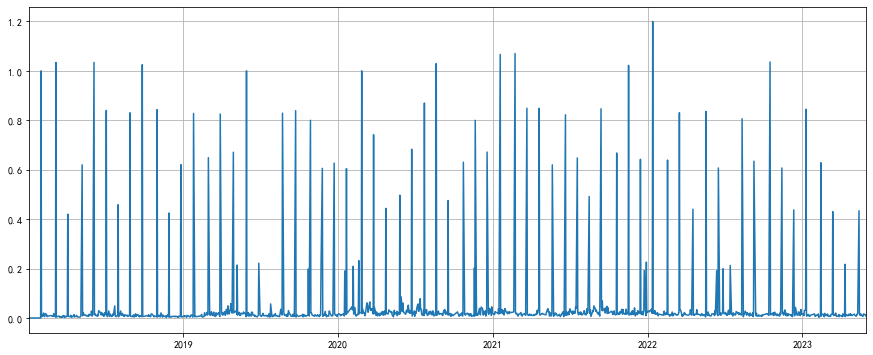

In [25]:
port_turnover.plot(figsize=(15,6),grid='on')

In [76]:
port_turnover.mean()

0.10847259412952984

In [102]:
netvalue_df

,port,zzzz,excess
2018-01-02,1.000000,1.000000,1.000000
2018-01-03,0.999995,1.012867,0.987291
2018-01-04,1.003830,1.014690,0.989298
2018-01-05,1.014482,1.023976,0.990729
2018-01-08,1.012558,1.024427,0.988414
2018-01-09,1.005474,1.019366,0.986372
2018-01-10,1.001107,1.019950,0.981525
2018-01-11,1.002540,1.017426,0.985369
2018-01-12,1.001156,1.018426,0.983043
2018-01-15,0.987246,1.012205,0.975342


<AxesSubplot:>

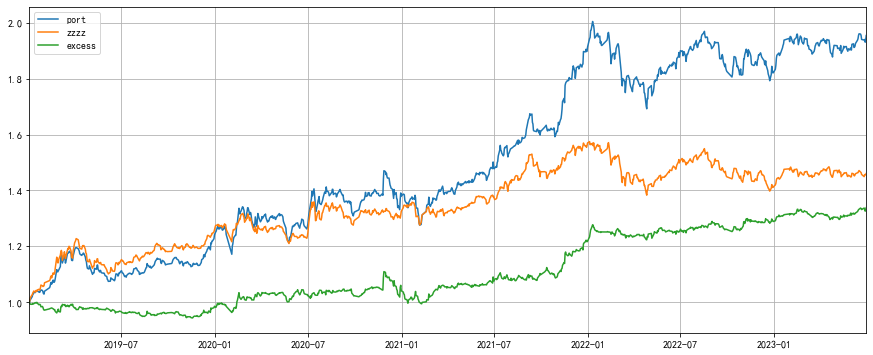

In [40]:
# 23/07/01东方--RSI5
df_benchindex = pro.query('cb_index_eodprices', code='000832.CSI', fields='date,s_dq_close')
df_benchindex = df_benchindex[(df_benchindex['date']>='20181130') & (df_benchindex['date']<='20230630')]
df_benchindex = df_benchindex.sort_values(by='date').set_index('date')
df_benchindex.index = pd.to_datetime(df_benchindex.index).date

netvalue_df = pd.DataFrame()
netvalue_df = pd.concat([port_netvalue_df.to_frame('port'),df_benchindex['s_dq_close'].to_frame('zzzz')],axis=1)
netvalue_df = netvalue_df.loc[date_s:date_e]
netvalue_df = netvalue_df/netvalue_df.iloc[0]
netvalue_df['excess'] = netvalue_df['port']/netvalue_df['zzzz']
netvalue_df.plot(figsize=(15,6),grid='on')

<AxesSubplot:>

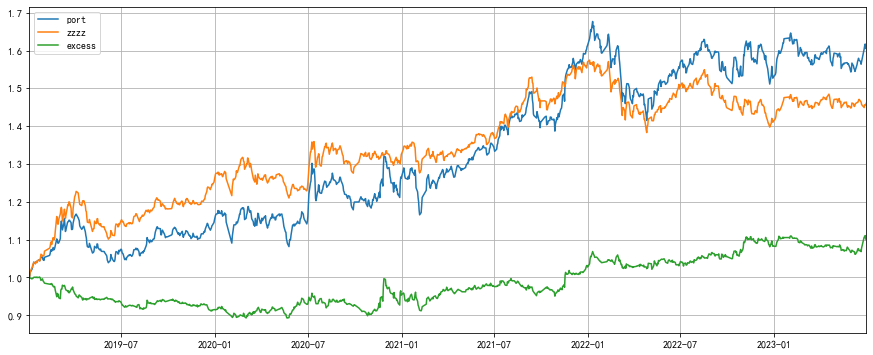

In [45]:
# factor_moderate_10
df_benchindex = pro.query('cb_index_eodprices', code='000832.CSI', fields='date,s_dq_close')
df_benchindex = df_benchindex[(df_benchindex['date']>='20181130') & (df_benchindex['date']<='20230630')]
df_benchindex = df_benchindex.sort_values(by='date').set_index('date')
df_benchindex.index = pd.to_datetime(df_benchindex.index).date

netvalue_df = pd.DataFrame()
netvalue_df = pd.concat([port_netvalue_df.to_frame('port'),df_benchindex['s_dq_close'].to_frame('zzzz')],axis=1)
netvalue_df = netvalue_df.loc[date_s:date_e]
netvalue_df = netvalue_df/netvalue_df.iloc[0]
netvalue_df['excess'] = netvalue_df['port']/netvalue_df['zzzz']
netvalue_df.plot(figsize=(15,6),grid='on')

<AxesSubplot:>

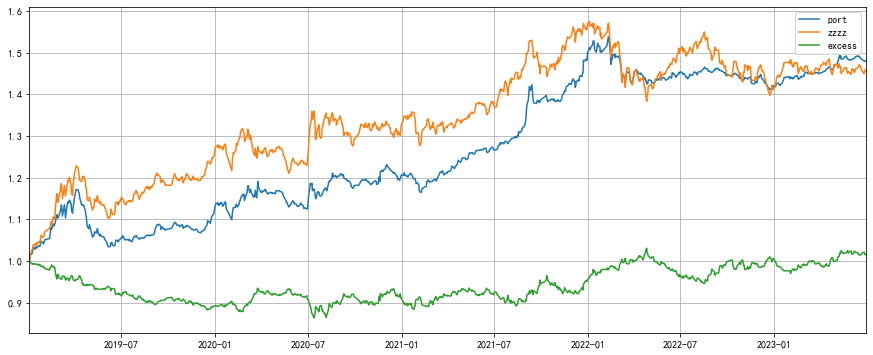

In [50]:
# factor_retvar_20
df_benchindex = pro.query('cb_index_eodprices', code='000832.CSI', fields='date,s_dq_close')
df_benchindex = df_benchindex[(df_benchindex['date']>='20181130') & (df_benchindex['date']<='20230630')]
df_benchindex = df_benchindex.sort_values(by='date').set_index('date')
df_benchindex.index = pd.to_datetime(df_benchindex.index).date

netvalue_df = pd.DataFrame()
netvalue_df = pd.concat([port_netvalue_df.to_frame('port'),df_benchindex['s_dq_close'].to_frame('zzzz')],axis=1)
netvalue_df = netvalue_df.loc[date_s:date_e]
netvalue_df = netvalue_df/netvalue_df.iloc[0]
netvalue_df['excess'] = netvalue_df['port']/netvalue_df['zzzz']
netvalue_df.plot(figsize=(15,6),grid='on')

<AxesSubplot:>

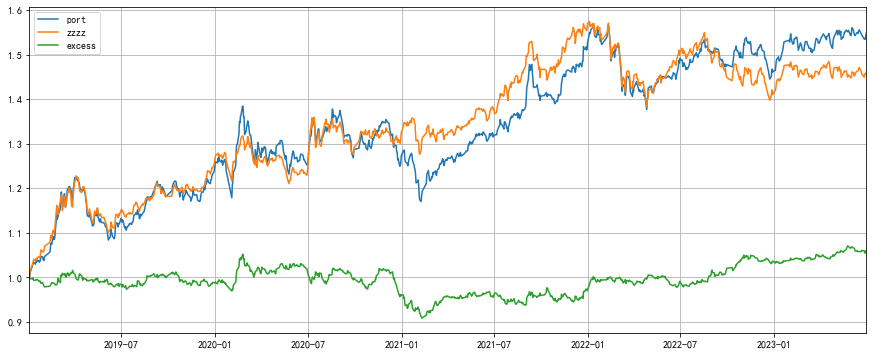

In [55]:
# factor_retskew_10_par
df_benchindex = pro.query('cb_index_eodprices', code='000832.CSI', fields='date,s_dq_close')
df_benchindex = df_benchindex[(df_benchindex['date']>='20181130') & (df_benchindex['date']<='20230630')]
df_benchindex = df_benchindex.sort_values(by='date').set_index('date')
df_benchindex.index = pd.to_datetime(df_benchindex.index).date

netvalue_df = pd.DataFrame()
netvalue_df = pd.concat([port_netvalue_df.to_frame('port'),df_benchindex['s_dq_close'].to_frame('zzzz')],axis=1)
netvalue_df = netvalue_df.loc[date_s:date_e]
netvalue_df = netvalue_df/netvalue_df.iloc[0]
netvalue_df['excess'] = netvalue_df['port']/netvalue_df['zzzz']
netvalue_df.plot(figsize=(15,6),grid='on')

<AxesSubplot:>

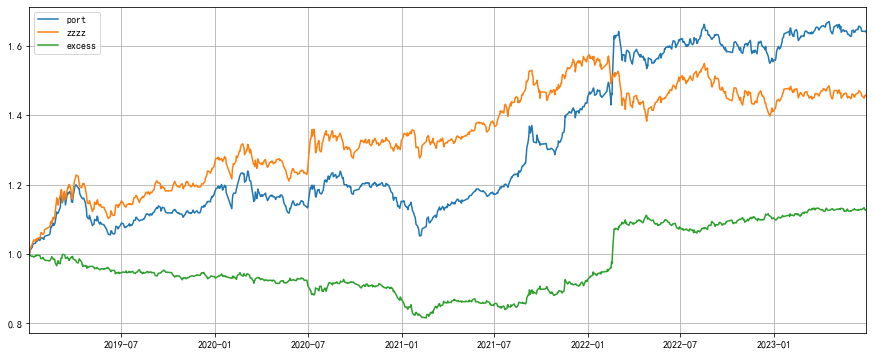

In [60]:
# factor_corrstd_10
df_benchindex = pro.query('cb_index_eodprices', code='000832.CSI', fields='date,s_dq_close')
df_benchindex = df_benchindex[(df_benchindex['date']>='20181130') & (df_benchindex['date']<='20230630')]
df_benchindex = df_benchindex.sort_values(by='date').set_index('date')
df_benchindex.index = pd.to_datetime(df_benchindex.index).date

netvalue_df = pd.DataFrame()
netvalue_df = pd.concat([port_netvalue_df.to_frame('port'),df_benchindex['s_dq_close'].to_frame('zzzz')],axis=1)
netvalue_df = netvalue_df.loc[date_s:date_e]
netvalue_df = netvalue_df/netvalue_df.iloc[0]
netvalue_df['excess'] = netvalue_df['port']/netvalue_df['zzzz']
netvalue_df.plot(figsize=(15,6),grid='on')

<AxesSubplot:>

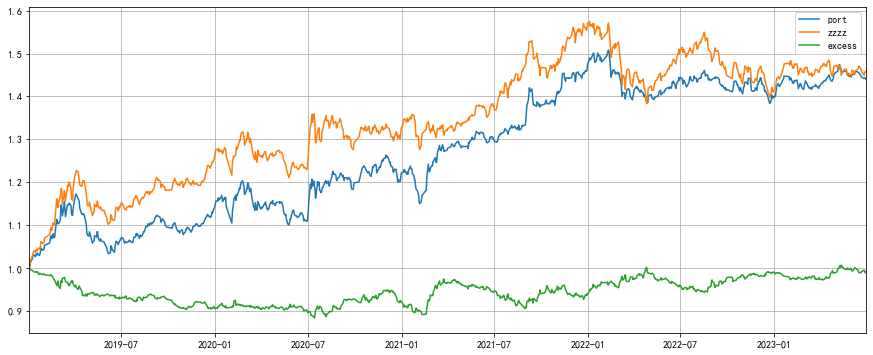

In [65]:
# factor_open_60
df_benchindex = pro.query('cb_index_eodprices', code='000832.CSI', fields='date,s_dq_close')
df_benchindex = df_benchindex[(df_benchindex['date']>='20181130') & (df_benchindex['date']<='20230630')]
df_benchindex = df_benchindex.sort_values(by='date').set_index('date')
df_benchindex.index = pd.to_datetime(df_benchindex.index).date

netvalue_df = pd.DataFrame()
netvalue_df = pd.concat([port_netvalue_df.to_frame('port'),df_benchindex['s_dq_close'].to_frame('zzzz')],axis=1)
netvalue_df = netvalue_df.loc[date_s:date_e]
netvalue_df = netvalue_df/netvalue_df.iloc[0]
netvalue_df['excess'] = netvalue_df['port']/netvalue_df['zzzz']
netvalue_df.plot(figsize=(15,6),grid='on')

<AxesSubplot:>

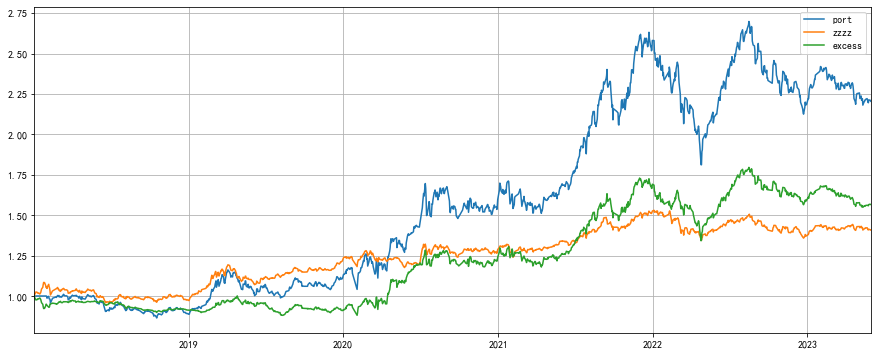

In [126]:
# 研报复现--30只
df_benchindex = pro.query('cb_index_eodprices', code='000832.CSI', fields='date,s_dq_close')
df_benchindex = df_benchindex[(df_benchindex['date']>='20171201') & (df_benchindex['date']<='20230601')]
df_benchindex = df_benchindex.sort_values(by='date').set_index('date')
df_benchindex.index = pd.to_datetime(df_benchindex.index).date

# df_csi500 = IndexEod_D.read_aindex_daily('000905.SH')
# df_csi500.index = pd.to_datetime(df_csi500['trade_date'])
netvalue_df = pd.DataFrame()
netvalue_df = pd.concat([port_netvalue_df.to_frame('port'),df_benchindex['s_dq_close'].to_frame('zzzz')],axis=1)
netvalue_df = netvalue_df.loc[date_s:date_e]
netvalue_df = netvalue_df/netvalue_df.iloc[0]
netvalue_df['excess'] = netvalue_df['port']/netvalue_df['zzzz']
# netvalue_df['excess_suanshu'] = (netvalue_df['port'].pct_change()-netvalue_df['csi500'].pct_change()).fillna(0).cumsum()+1
# netvalue_df['excess_suanshu_prot_JCLZ'] = (netvalue_df['port'].pct_change()-netvalue_df['JCLZ500'].pct_change()).fillna(0).cumsum()+1
# netvalue_df['excess_suanshu_JCLZ'] = (netvalue_df['JCLZ500'].pct_change()-netvalue_df['csi500'].pct_change()).fillna(0).cumsum()+1
netvalue_df.plot(figsize=(15,6),grid='on')

<AxesSubplot:>

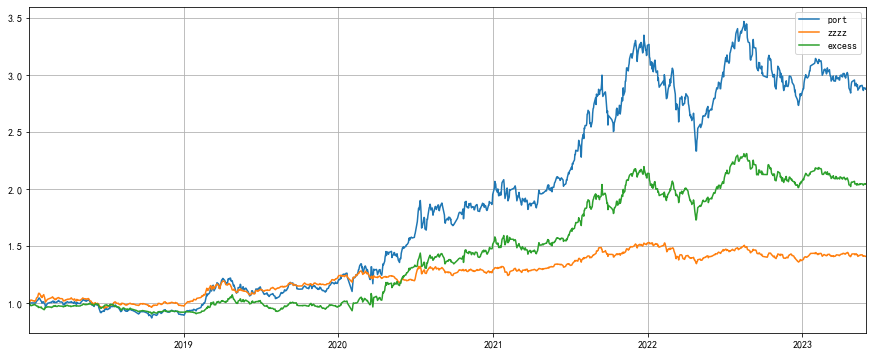

In [123]:
# 研报复现--20只
df_benchindex = pro.query('cb_index_eodprices', code='000832.CSI', fields='date,s_dq_close')
df_benchindex = df_benchindex[(df_benchindex['date']>='20171201') & (df_benchindex['date']<='20230601')]
df_benchindex = df_benchindex.sort_values(by='date').set_index('date')
df_benchindex.index = pd.to_datetime(df_benchindex.index).date

# df_csi500 = IndexEod_D.read_aindex_daily('000905.SH')
# df_csi500.index = pd.to_datetime(df_csi500['trade_date'])
netvalue_df = pd.DataFrame()
netvalue_df = pd.concat([port_netvalue_df.to_frame('port'),df_benchindex['s_dq_close'].to_frame('zzzz')],axis=1)
netvalue_df = netvalue_df.loc[date_s:date_e]
netvalue_df = netvalue_df/netvalue_df.iloc[0]
netvalue_df['excess'] = netvalue_df['port']/netvalue_df['zzzz']
# netvalue_df['excess_suanshu'] = (netvalue_df['port'].pct_change()-netvalue_df['csi500'].pct_change()).fillna(0).cumsum()+1
# netvalue_df['excess_suanshu_prot_JCLZ'] = (netvalue_df['port'].pct_change()-netvalue_df['JCLZ500'].pct_change()).fillna(0).cumsum()+1
# netvalue_df['excess_suanshu_JCLZ'] = (netvalue_df['JCLZ500'].pct_change()-netvalue_df['csi500'].pct_change()).fillna(0).cumsum()+1
netvalue_df.plot(figsize=(15,6),grid='on')

<AxesSubplot:>

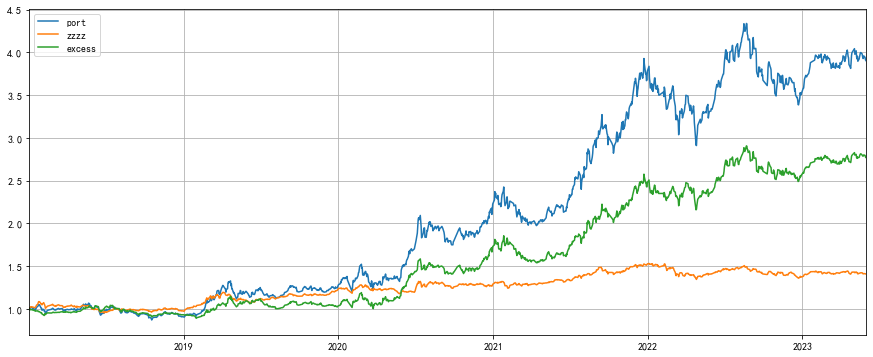

In [114]:
# 研报复现
df_benchindex = pro.query('cb_index_eodprices', code='000832.CSI', fields='date,s_dq_close')
df_benchindex = df_benchindex[(df_benchindex['date']>='20171201') & (df_benchindex['date']<='20230601')]
df_benchindex = df_benchindex.sort_values(by='date').set_index('date')
df_benchindex.index = pd.to_datetime(df_benchindex.index).date

# df_csi500 = IndexEod_D.read_aindex_daily('000905.SH')
# df_csi500.index = pd.to_datetime(df_csi500['trade_date'])
netvalue_df = pd.DataFrame()
netvalue_df = pd.concat([port_netvalue_df.to_frame('port'),df_benchindex['s_dq_close'].to_frame('zzzz')],axis=1)
netvalue_df = netvalue_df.loc[date_s:date_e]
netvalue_df = netvalue_df/netvalue_df.iloc[0]
netvalue_df['excess'] = netvalue_df['port']/netvalue_df['zzzz']
# netvalue_df['excess_suanshu'] = (netvalue_df['port'].pct_change()-netvalue_df['csi500'].pct_change()).fillna(0).cumsum()+1
# netvalue_df['excess_suanshu_prot_JCLZ'] = (netvalue_df['port'].pct_change()-netvalue_df['JCLZ500'].pct_change()).fillna(0).cumsum()+1
# netvalue_df['excess_suanshu_JCLZ'] = (netvalue_df['JCLZ500'].pct_change()-netvalue_df['csi500'].pct_change()).fillna(0).cumsum()+1
netvalue_df.plot(figsize=(15,6),grid='on')

<AxesSubplot:>

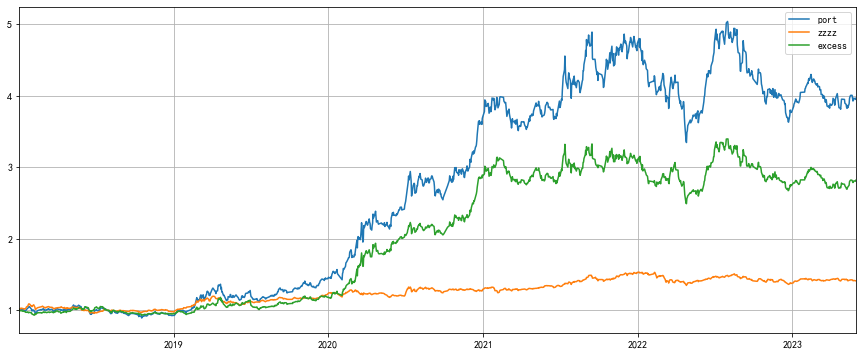

In [101]:
# 换仓天数20天
df_benchindex = pro.query('cb_index_eodprices', code='000832.CSI', fields='date,s_dq_close')
df_benchindex = df_benchindex[(df_benchindex['date']>='20171201') & (df_benchindex['date']<='20230601')]
df_benchindex = df_benchindex.sort_values(by='date').set_index('date')
df_benchindex.index = pd.to_datetime(df_benchindex.index).date

# df_csi500 = IndexEod_D.read_aindex_daily('000905.SH')
# df_csi500.index = pd.to_datetime(df_csi500['trade_date'])
netvalue_df = pd.DataFrame()
netvalue_df = pd.concat([port_netvalue_df.to_frame('port'),df_benchindex['s_dq_close'].to_frame('zzzz')],axis=1)
netvalue_df = netvalue_df.loc[date_s:date_e]
netvalue_df = netvalue_df/netvalue_df.iloc[0]
netvalue_df['excess'] = netvalue_df['port']/netvalue_df['zzzz']
# netvalue_df['excess_suanshu'] = (netvalue_df['port'].pct_change()-netvalue_df['csi500'].pct_change()).fillna(0).cumsum()+1
# netvalue_df['excess_suanshu_prot_JCLZ'] = (netvalue_df['port'].pct_change()-netvalue_df['JCLZ500'].pct_change()).fillna(0).cumsum()+1
# netvalue_df['excess_suanshu_JCLZ'] = (netvalue_df['JCLZ500'].pct_change()-netvalue_df['csi500'].pct_change()).fillna(0).cumsum()+1
netvalue_df.plot(figsize=(15,6),grid='on')

<AxesSubplot:>

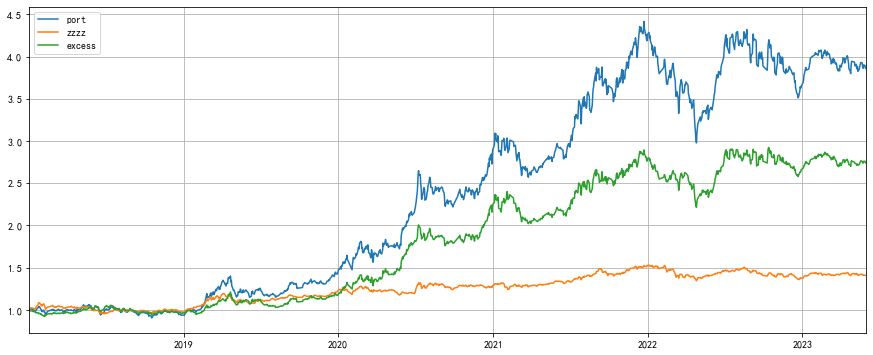

In [48]:
# 研报+筛成交量后20%+1亿剩余余额+前10只+20天换仓
df_benchindex = pro.query('cb_index_eodprices', code='000832.CSI', fields='date,s_dq_close')
df_benchindex = df_benchindex[(df_benchindex['date']>='20171201') & (df_benchindex['date']<='20230601')]
df_benchindex = df_benchindex.sort_values(by='date').set_index('date')
df_benchindex.index = pd.to_datetime(df_benchindex.index).date

# df_csi500 = IndexEod_D.read_aindex_daily('000905.SH')
# df_csi500.index = pd.to_datetime(df_csi500['trade_date'])
netvalue_df = pd.DataFrame()
netvalue_df = pd.concat([port_netvalue_df.to_frame('port'),df_benchindex['s_dq_close'].to_frame('zzzz')],axis=1)
netvalue_df = netvalue_df.loc[date_s:date_e]
netvalue_df = netvalue_df/netvalue_df.iloc[0]
netvalue_df['excess'] = netvalue_df['port']/netvalue_df['zzzz']
# netvalue_df['excess_suanshu'] = (netvalue_df['port'].pct_change()-netvalue_df['csi500'].pct_change()).fillna(0).cumsum()+1
# netvalue_df['excess_suanshu_prot_JCLZ'] = (netvalue_df['port'].pct_change()-netvalue_df['JCLZ500'].pct_change()).fillna(0).cumsum()+1
# netvalue_df['excess_suanshu_JCLZ'] = (netvalue_df['JCLZ500'].pct_change()-netvalue_df['csi500'].pct_change()).fillna(0).cumsum()+1
netvalue_df.plot(figsize=(15,6),grid='on')

In [21]:
netvalue_df.resample('1Y').last().pct_change()

,port,zzzz,excess
2018-12-31,NaN,NaN,NaN
2019-12-31,0.216510,0.251475,-0.027939
2020-12-31,0.328052,0.052549,0.261748
2021-12-31,0.412495,0.184811,0.192169
2022-12-31,-0.059156,-0.100167,0.045576
2023-12-31,0.124093,0.049138,0.071444


In [23]:
# ytm